In [ ]:
# Import necessary libraries

import time
import pandas as pd
import requests
import io
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')
from datetime import *


# Scrapping PSI Data 

The data for Singapore Pollutant Standards Index (PSI) is obtained from data.gov.sg. The link for the data source can be found here: https://data.gov.sg/dataset/psi?view_id=496c77eb-6add-4e9b-9883-17864cedfe9f&resource_id=82776919-0de1-4faf-bd9e-9c997f9a729d.

The PSI data is available from 9 Feb 2016 to 20 Sep 2019, and this time period will be used for analysis. 

To obtain PSI data, some simplifying assumptions are made. Firstly, the 24 hourly PSI data, which is available every hour, is taken at the start of the day, at 7AM. Secondly, the 24 hourly PSI data is used over other indexes like PM10 and PM2.5 as the 24h PSI data reflects the highest index for that hour. For instance, if PM10 index is the highest for that hour, the 24h PSI index will be equal to PM10 index. Lastly, the national index is used over regional data (North, South, East, West and Central) to simplify analysis.

In [5]:
# Request PSI information from server


all_response = {}

# set up time iteration
# time period to be PSI data from inception (from 9 Feb 2016 to 20 Sep 2019)

start_date = date(2016, 2, 9)
end_date = date(2019, 9, 20)
delta = timedelta(days=1)
while start_date <= end_date:
    current_date = start_date.strftime("%Y-%m-%d")
    
    #############################################################################
    # request data
    url = "https://api.data.gov.sg/v1/environment/psi?date=" #base URL
    new_url = url + current_date
    resp = requests.get(new_url)
#     print(resp)
    resp_dict = resp.json()
    
    
    time.sleep(0.5)


    # take the data from 7:00AM as representative of entire day data
    # take data from 24h psi index, then take national reading

    
    try:
        PSI = resp_dict['items'][6]['readings']['psi_twenty_four_hourly']['national']
    except:
        PSI = 0
        pass
    
    
    
    if "Date" not in all_response:
        all_response["Date"] = [current_date]
    else:
        all_response["Date"].append(current_date)
    if "PSI" not in all_response:
        all_response["PSI"] = [PSI]
    else:
        all_response["PSI"].append(PSI)
    
    
    start_date += delta

print(all_response)

PSI_df = pd.DataFrame(all_response)
PSI_df.head()

PSI_df.to_csv('PSI_Data_extended.csv')

{'Date': ['2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13', '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17', '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21', '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25', '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29', '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04', '2016-03-05', '2016-03-06', '2016-03-07', '2016-03-08', '2016-03-09', '2016-03-10', '2016-03-11', '2016-03-12', '2016-03-13', '2016-03-14', '2016-03-15', '2016-03-16', '2016-03-17', '2016-03-18', '2016-03-19', '2016-03-20', '2016-03-21', '2016-03-22', '2016-03-23', '2016-03-24', '2016-03-25', '2016-03-26', '2016-03-27', '2016-03-28', '2016-03-29', '2016-03-30', '2016-03-31', '2016-04-01', '2016-04-02', '2016-04-03', '2016-04-04', '2016-04-05', '2016-04-06', '2016-04-07', '2016-04-08', '2016-04-09', '2016-04-10', '2016-04-11', '2016-04-12', '2016-04-13', '2016-04-14', '2016-04-15', '2016-04-16', '2016-04-17', '2016-04-18', '2016-04-1

# Obtain Data from polyclinic attendees

To obtain data on people falling sick, this project uses 2 different dependent variables, namely (1) number of Upper Respiratiory Tract Infections (URTI) polyclinic outpatients per week and (2) total number of polyclinic outpatients. For this part of the analysis, the number of URTI patients will be used. According to www.gleneagles.com.sg, an URTI is an infection of your upper respiratory tract and it includes your throat, nose, pharynx, larynx, sinuses, and trachea (windpipe). Hence, for this part of the analysis, our hypothesis is that the air pollution causes respiratory-related illnesses. 

Data for this part is obtained from https://data.gov.sg/dataset/average-daily-polyclinic-attendances-selected-diseases?view_id=a2134d83-7ae6-4a1d-ba38-a9b01f1d428e&resource_id=dd4dcaac-aa8d-49de-a96a-b809f8d3ae0d. 

In [153]:
# import data from polyclinic attendees
# settle illnesses data

illness_df = pd.read_csv("average-daily-polyclinic-attendances-for-selected-diseases.csv")

cond_only_URTI = illness_df["disease"].isin(["Acute Upper Respiratory Tract infections"]) # filter only for URTI
narrow_down_to_URTI = illness_df[cond_only_URTI]
narrow_down_to_URTI.drop(columns = "disease", inplace = True) #removing irrelevant data

def reformat_week(week):
    return int(week[-2:])
def get_year(week):
    return int(week[:4])

narrow_down_to_URTI["Week"] = narrow_down_to_URTI["epi_week"].apply(reformat_week)
narrow_down_to_URTI["Year"] = narrow_down_to_URTI["epi_week"].apply(get_year)


# Consolidate all cases to end of week date
narrow_down_to_URTI['WeekStartDate'] = pd.to_datetime(narrow_down_to_URTI.Year.astype(str), format='%Y') + \
             pd.to_timedelta(narrow_down_to_URTI.Week.mul(7).astype(str) + ' days') 
#             pd.to_timedelta('7 days')



def date_to_weeknumber(inp):
    return inp.strftime("%U")

narrow_down_to_URTI['verify_week'] = narrow_down_to_URTI['WeekStartDate'].apply(date_to_weeknumber)


# filter according to working range (2016 WW6 to 2019 WW38)
mask = (narrow_down_to_URTI['WeekStartDate'] > '2016-02-09')

narrow_down_to_URTI= narrow_down_to_URTI[mask]

narrow_down_to_URTI.reset_index(inplace = True)
narrow_down_to_URTI
# URTI_gb.drop(columns = "Week", inplace = True)
# URTI_gb

,index,epi_week,no._of_cases,Week,Year,WeekStartDate,verify_week
0,856,2016-W06,3740,6,2016,2016-02-12,06
1,860,2016-W07,3174,7,2016,2016-02-19,07
2,864,2016-W08,3148,8,2016,2016-02-26,08
3,868,2016-W09,3001,9,2016,2016-03-04,09
4,872,2016-W10,2702,10,2016,2016-03-11,10
5,876,2016-W11,2382,11,2016,2016-03-18,11
6,880,2016-W12,2596,12,2016,2016-03-25,12
7,884,2016-W13,2530,13,2016,2016-04-01,13
8,888,2016-W14,2417,14,2016,2016-04-08,14
9,892,2016-W15,2383,15,2016,2016-04-15,15


# Data manipulation

For the independent variable (PSI index), data is available on a daily basis. However, the data available for the dependent variable (URTI cases/week) is only available on a weekly basis. Hence, the following code converts the daily data for PSI index to weekly by taking the average of the week's data.

In [154]:
# consolidate PSI data to match week
PSI_df = pd.read_csv('PSI_Data_extended.csv')
PSI_df['Date'] = pd.to_datetime(PSI_df['Date'])

# start week is WW6/2016, end date is WW11/2019
mask = (PSI_df['Date'] > '2016-02-08') & (PSI_df['Date'] < '2019-03-16')
PSI_df = PSI_df[mask]

# convert date column to date type
PSI_df['Date'] = pd.to_datetime(PSI_df['Date'])

# breakdown Date to Week number and Yeat
PSI_df['Week_Number_of_Year'] = PSI_df['Date'].dt.week
PSI_df['Year_PSI'] = PSI_df['Date'].dt.year


# find mean of PSI by Week number and Year
PSI_df_gb = PSI_df.groupby(["Week_Number_of_Year","Year_PSI"], sort = False).mean() # find mean of PSI by Week number and Year
PSI_df_gb.reset_index(inplace = True)



PSI_df_gb.head()


,Week_Number_of_Year,Year_PSI,Unnamed: 0,PSI
0,6,2016,2.5,50.000000
1,7,2016,9.0,50.714286
2,8,2016,16.0,46.285714
3,9,2016,23.0,51.571429
4,10,2016,30.0,53.142857


# Combining Dataframes of IV and DV

In this section, the dataframes of the independent and dependent variables are combined, and the resultant dataframe is cleaned.

In [164]:
# concat dataframes

df_combined = pd.concat([PSI_df_gb,narrow_down_to_URTI], axis = 1)
display(df_combined.head())


# obtain 1 dataframe and dropping repetitive columns
df_combined_filtered = df_combined[['Week_Number_of_Year', 'Year', 'PSI', 'no._of_cases', 'WeekStartDate']]

df_combined_filtered.head()

,Week_Number_of_Year,Year_PSI,Unnamed: 0,PSI,index,epi_week,no._of_cases,Week,Year,WeekStartDate,verify_week
0,6,2016,2.5,50.000000,856,2016-W06,3740,6,2016,2016-02-12,06
1,7,2016,9.0,50.714286,860,2016-W07,3174,7,2016,2016-02-19,07
2,8,2016,16.0,46.285714,864,2016-W08,3148,8,2016,2016-02-26,08
3,9,2016,23.0,51.571429,868,2016-W09,3001,9,2016,2016-03-04,09
4,10,2016,30.0,53.142857,872,2016-W10,2702,10,2016,2016-03-11,10


,Week_Number_of_Year,Year,PSI,no._of_cases,WeekStartDate
0,6,2016,50.000000,3740,2016-02-12
1,7,2016,50.714286,3174,2016-02-19
2,8,2016,46.285714,3148,2016-02-26
3,9,2016,51.571429,3001,2016-03-04
4,10,2016,53.142857,2702,2016-03-11


# Finding correlation between DV and IV using R-squared value

Linear regression is then carried out on the IV and DV to determine if the PSI index affects the number of URTI cases per week. 

In [156]:
# finding r2 value
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score

regression = linear_model.LinearRegression()

x = df_combined_filtered[["PSI"]] # independent variable
y = df_combined_filtered[["no._of_cases"]] # dependent variable

regression.fit(x,y)

predicted_for_y = regression.predict(x)

r2 = r2_score(y, predicted_for_y)
print(r2)

0.01562669031287167


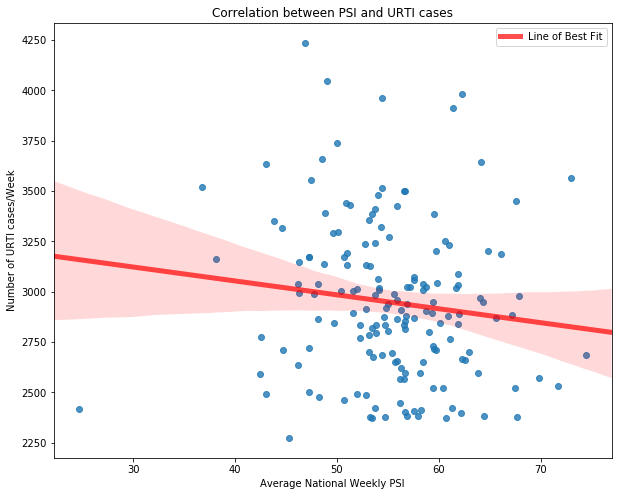

In [157]:
# Plotting scatter plot with regression line using sns.regplot()
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

sns.regplot(x = df_combined_filtered["PSI"] , 
            y = df_combined_filtered["no._of_cases"],
            line_kws={"color":"r","alpha":0.7,"lw":5}, 
            ax=ax1,)

plt.xlabel("Average National Weekly PSI")
plt.ylabel("Number of URTI cases/Week")
plt.title("Correlation between PSI and URTI cases")
plt.legend(labels = ["Line of Best Fit"])
plt.show()

# Conclusion

The Hypothesis that air pollution causes more people to have respiratory tract infection is not proven, as the coefficient of determination (R-squared) value is very small, at <b>0.0156</b>. Furthermore, from the plot, it appears the number of URTI cases/week falls as PSI increases. This suggests that URTI cases might not give accurate information on people falling sick. 

Hence, to investigate further, the total outpatient polyclinic atttendees will be used as the dependent variable in the following section.

# Part 2:

The data for total outpatient polyclinic attendees are taken from: https://www.tablebuilder.singstat.gov.sg/publicfacing/createDataTable.action?refId=15183

In [158]:
# read and format data of all outpatient polyclinic attendees
all_outpat_df = pd.read_csv('average-daily-polyclinic-attendances-all.csv')

all_outpat_df = all_outpat_df.transpose()

all_outpat_df.reset_index(inplace = True)
all_outpat_df.columns = all_outpat_df.iloc[0]
all_outpat_df=all_outpat_df.drop([0])
all_outpat_df = all_outpat_df.rename({' Variables ':'Date', ' Polyclinics ':  'Polyclinics' }, axis = 1)

all_outpat_df['Polyclinics'] = all_outpat_df['Polyclinics'].apply(lambda x: x.replace(',', ''))
all_outpat_df['Polyclinics'] = all_outpat_df['Polyclinics'].apply(lambda x: float(x))

poly_df = all_outpat_df[['Date', 'Polyclinics']]
poly_df.head()

,Date,Polyclinics
1,1987 Jan,240542.0
2,1987 Feb,254215.0
3,1987 Mar,262136.0
4,1987 Apr,245888.0
5,1987 May,219142.0


# Data Cleaning

The data obtained is then cleaned and narrowed down to the relevant time frame (08 Feb 2016 - 16 Mar 2019).

In [159]:
# Format date

poly_df['Formatted_date'] = pd.to_datetime(poly_df['Date'])
poly_df

# filter to relevant date

mask = (poly_df['Formatted_date'] > '2016-02-08') & (poly_df['Formatted_date'] < '2019-03-16')
poly_df = poly_df[mask]
poly_df.reset_index(inplace = True)
poly_df.head()

,index,Date,Polyclinics,Formatted_date
0,351,2016 Mar,461900.0,2016-03-01
1,352,2016 Apr,442411.0,2016-04-01
2,353,2016 May,434117.0,2016-05-01
3,354,2016 Jun,442582.0,2016-06-01
4,355,2016 Jul,443474.0,2016-07-01


# Data manipulation

For the independent variable (PSI index), data is available on a daily basis. However, the data available for the dependent variable (total polyclinic outpatients/month) is only available on a monthly basis. Hence, the following code converts the daily data for PSI index to monthly by taking the average of the month's data.

In [160]:
# consolidate PSI data to match month
PSI_df_part_2 = pd.read_csv('PSI_Data_extended.csv')
PSI_df_part_2['Date'] = pd.to_datetime(PSI_df_part_2['Date'])

# start week is WW6/2016, end date is WW11/2019
mask = (PSI_df_part_2['Date'] >= '2016-03-01') & (PSI_df_part_2['Date'] < '2019-03-16')
PSI_df_part_2 = PSI_df_part_2[mask]

# convert date column to date type
PSI_df_part_2['Date'] = pd.to_datetime(PSI_df_part_2['Date'])

# breakdown Date to Week number and Year

PSI_df_part_2['Year_PSI'] = PSI_df_part_2['Date'].dt.year
PSI_df_part_2['Month'] = PSI_df_part_2['Date'].dt.month

# find mean of PSI by Month and Year
PSI_df_gb_2 = PSI_df_part_2.groupby(["Month","Year_PSI"], sort = False).mean() # find mean of PSI by Week number and Year
PSI_df_gb_2.reset_index(inplace = True)



PSI_df_gb_2.head()


,Month,Year_PSI,Unnamed: 0,PSI
0,3,2016,36.0,58.774194
1,4,2016,66.5,51.566667
2,5,2016,97.0,51.612903
3,6,2016,127.5,57.433333
4,7,2016,158.0,60.548387


# Combining Dataframes of IV and DV

In this section, the dataframes of the independent and dependent variables are combined, and the resultant dataframe is cleaned.

In [165]:
# concat dataframes

df_combined_pt2 = pd.concat([PSI_df_gb_2,poly_df], axis = 1)


# obtain 1 dataframe and dropping repetitive columns
df_combined_filtered_pt2 = df_combined_pt2[['Month', 'Year_PSI', 'PSI', 'Polyclinics', 'Formatted_date']]

df_combined_filtered_pt2.head()

,Month,Year_PSI,PSI,Polyclinics,Formatted_date
0,3,2016,58.774194,461900.0,2016-03-01
1,4,2016,51.566667,442411.0,2016-04-01
2,5,2016,51.612903,434117.0,2016-05-01
3,6,2016,57.433333,442582.0,2016-06-01
4,7,2016,60.548387,443474.0,2016-07-01


# Finding correlation between DV and IV using R-squared value

Linear regression is then carried out on the IV and DV to determine if the PSI index affects the number of polyclinic outpatients per month.

In [162]:
# finding r2 value
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score

regression = linear_model.LinearRegression()

x = df_combined_filtered_pt2[["PSI"]] # independent variable
y = df_combined_filtered_pt2[["Polyclinics"]] # dependent variable

regression.fit(x,y)

predicted_for_y = regression.predict(x)

r2 = r2_score(y, predicted_for_y)
print(r2)

0.001468582858391132


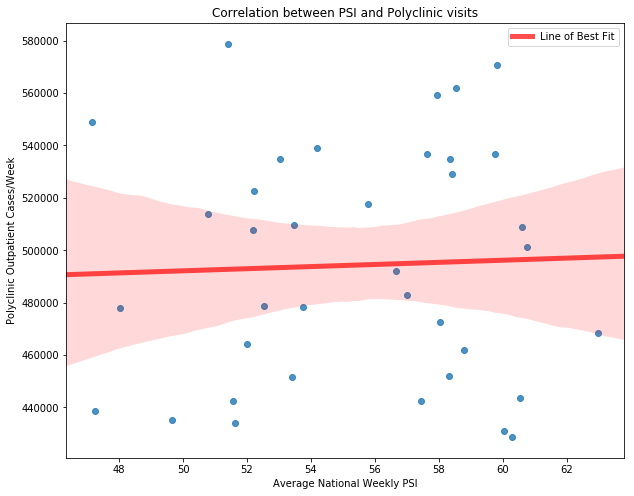

In [163]:
# Plotting scatter plot with regression line using sns.regplot()
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

sns.regplot(x = df_combined_filtered_pt2["PSI"] , 
            y = df_combined_filtered_pt2["Polyclinics"],
            line_kws={"color":"r","alpha":0.7,"lw":5}, 
            ax=ax1,)

plt.xlabel("Average National Weekly PSI")
plt.ylabel("Polyclinic Outpatient Cases/Week")
plt.title("Correlation between PSI and Polyclinic visits")
plt.legend(labels = ["Line of Best Fit"])
plt.show()

# Conclusion

The Hypothesis that air pollution causes more people to have fall sick is once again <b>not proven</b>, as the coefficient of determination (R-squared) value is very small, at <b>0.00146</b>. 

Hence, this study found no strong evidence that air pollution causes people to fall sick. This could be due to several reasons. One possible reason is that the vulnerable population (those with asthma, heart disease etc) are prepared with face masks and stay indoors, hence limiting their exposure to the haze. Also, the lack of correlation could be due to sporadic exposure to the haze, as Singapore experiences hazy conditions rather occasionally. 